# Lesson 2

## Purpose

In this lesson we will learn how to load an existing model and look inside the column.

## Load CADETSettings

This imports all the standard libraries, finds CADET and find and creates all the lesson folders.

In [1]:
%run CADETSettings.ipynb

CADET was found. Continue to the next step.


## Load an existing model and modify it

In this example we will load the model from Lesson 1 and modify it

* LUMPED_RATE_MODEL_WITH_PORES to GENERAL_RATE_MODEL
* Change adsorption to LANGMUIR

This way we can look inside the beads and at binding.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_2/example_0/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


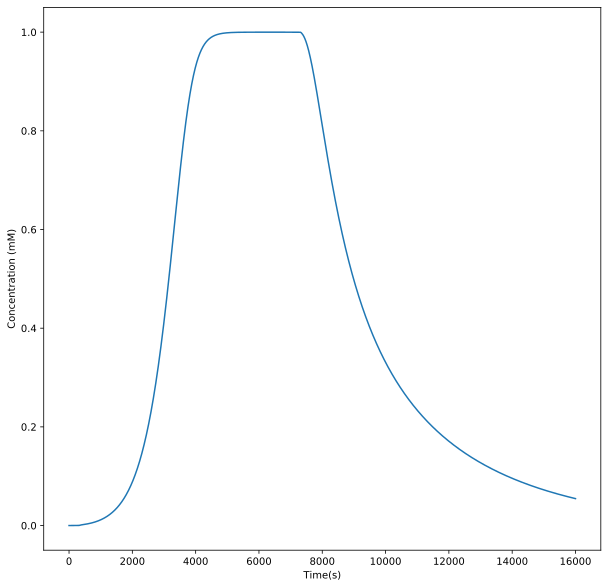

In [2]:
#grm model
example_dir_0 = lesson_2 / "example_0"
example_dir_0.mkdir(exist_ok = True)

example0 = Cadet()

#load a previous simulation to use as the base for the new one
example0.filename = (lesson_1 / "example_0" / 'example.h5').as_posix()
example0.load()

#give a filename for where the simulation should be saved
example0.filename = (example_dir_0 / 'example.h5').as_posix()

#take the original simulation and change just the parts we need

#create a column
example0.root.input.model.unit_001.unit_type = 'GENERAL_RATE_MODEL'
example0.root.input.model.unit_001.film_diffusion = [2e-7,]
example0.root.input.model.unit_001.par_diffusion = [5e-11,]
example0.root.input.model.unit_001.par_surfdiffusion = [0.0,]

example0.root.input.model.unit_001.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'
example0.root.input.model.unit_001.adsorption.mcl_ka = [2.0,]
example0.root.input.model.unit_001.adsorption.mcl_kd = [1.0,]
example0.root.input.model.unit_001.adsorption.mcl_qmax = [10.0,]
example0.root.input.model.unit_001.adsorption.is_kinetic = 1


#discretization column settings
example0.root.input.model.unit_001.discretization.npar = 10
example0.root.input.model.unit_001.discretization.nbound = [1,]
example0.root.input.model.unit_001.discretization.par_disc_type = 'EQUIDISTANT_PAR'

#set what values get saved
example0.root.input['return'].unit_000.write_solution_inlet = 1

example0.root.input['return'].unit_001.write_solution_particle = 1
example0.root.input['return'].unit_001.write_solution_solid = 1
example0.root.input['return'].unit_001.write_solution_bulk = 1

example0.root.input['return'].unit_002.write_solution_outlet = 1

#set the times that the simulator writes out data for
example0.root.input.solver.user_solution_times = numpy.linspace(0, 16000, 16001)

#solver settings
example0.root.input.solver.sections.section_times = [0.0, 7000.0, 16000.0]

#save the simulation
example0.save()

#run the simulation
data = example0.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example0.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example0.root.output.solution.solution_times,
                        example0.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_0 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Look at the bulk concentration inside the column over time

Set write_solution_bulk = 1 to write out the liquid phase concentration between the particles along the entire column at all time points.

You can read this using

```python
solution_bulk[time, axial position, component]
```


In [3]:
ymax = numpy.max(example0.root.output.solution.unit_001.solution_bulk[:]) * 1.1

def graph_column(time=0):
    position = list(range(example0.root.input.model.unit_001.discretization.ncol))
    values = example0.root.output.solution.unit_001.solution_bulk[time, :, 0]
    plt.figure(figsize=[15,5])
    plt.plot(position, values)
    plt.ylim(0, ymax)
    plt.xlabel('Column Length')
    plt.ylabel('Interstitial Concentration (mM)')

style = {'description_width': 'initial'}
interact(graph_column, time=widgets.IntSlider(min=0, max=len(example0.root.output.solution.solution_times) -1, step=10, value=0, layout={'width': '800px'}, style=style, description='Time'))

interactive(children=(IntSlider(value=0, description='Time', layout=Layout(width='800px'), max=16000, step=10,…

<function __main__.graph_column(time=0)>

## Look inside the particles

Set write_solution_particle = 1 to write out the liquid phase concentration within the particles at each particle shell along the entire column at all time points.

You can read this using

```python
solution_particle[time, axial position, particle position, component]
```


If you want to look at the solid phase concentration then set write_solution_solid = 1 to write out the bound phase concentration within the particles at each particle shell along the entire column at all time points.

```python
solution_solid[time, axial position, particle position, component]
```

In [4]:
ymax = numpy.max(example0.root.output.solution.unit_001.solution_particle[:]) * 1.1

def graph_particle(time=0, col_pos=0):
    plt.figure(figsize=(15,10))
    position = list(range(example0.root.input.model.unit_001.discretization.npar))
    values = example0.root.output.solution.unit_001.solution_particle[time, col_pos, :, 0]
    plt.plot(position, values)
    plt.ylim(0, ymax)
    plt.xlabel('Particle Radius (0 = center)')
    plt.ylabel('Liquid Concentration (mM)')

style = {'description_width': 'initial'}
interact(graph_particle, time=widgets.IntSlider(min=0, max=len(example0.root.output.solution.solution_times) -1, step=10, value=0, layout={'width': '800px'}, style=style, description='Time'),
         col_pos=widgets.IntSlider(min=0, max=example0.root.input.model.unit_001.discretization.ncol - 1, step=1, value=0, layout={'width': '800px'}, style=style, description='Column Position'))

interactive(children=(IntSlider(value=0, description='Time', layout=Layout(width='800px'), max=16000, step=10,…

<function __main__.graph_particle(time=0, col_pos=0)>

In [5]:
ymax = numpy.max(example0.root.output.solution.unit_001.solution_solid[:]) * 1.1

def graph_particle(time=0, col_pos=0):
    plt.figure(figsize=(15,10))
    position = list(range(example0.root.input.model.unit_001.discretization.npar))
    values = example0.root.output.solution.unit_001.solution_solid[time, col_pos, :, 0]
    plt.plot(position, values)
    plt.ylim(0, ymax)
    plt.xlabel('Particle Radius (0 = center)')
    plt.ylabel('Bound Concentration (mM)')

, style=style, description='Time'
interact(graph_particle, time=widgets.IntSlider(min=0, max=len(example0.root.output.solution.solution_times) -1, step=10, value=0, layout={'width': '800px'}, style=style, description='Time'),
         col_pos=widgets.IntSlider(min=0, max=example0.root.input.model.unit_001.discretization.ncol - 1, step=1, value=0, layout={'width': '800px'}, style=style, description='Column Position'))

interactive(children=(IntSlider(value=0, description='Time', layout=Layout(width='800px'), max=16000, step=10,…

<function __main__.graph_particle(time=0, col_pos=0)>